In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import uniform, randint
import warnings
from sklearn.exceptions import ConvergenceWarning
import joblib
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [83]:
df=pd.read_csv('drive/MyDrive/ML/proyecto/X_train.csv')
df.head()

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,...,trackLength,albumLength,ArtistEqualsChannel,album_tracks,available_markets,album_release_days,Album_type_album,Album_type_compilation,Album_type_single,target
0,0.407,0.358,9.0,-12.908,0.0343,0.829,0.424000,0.0827,0.267,92.292,...,11,7,0,9,184,19183,1,0,0,78507272.0
1,0.463,0.325,11.0,-14.762,0.0301,0.197,0.000000,0.0641,0.386,135.728,...,22,12,0,10,2,11778,1,0,0,134634501.0
2,0.253,0.189,8.0,-17.741,0.0348,0.856,0.000004,0.1120,0.143,133.591,...,55,33,0,12,25,22005,1,0,0,18549494.0
3,0.828,0.539,1.0,-7.300,0.2250,0.205,0.000038,0.3050,0.680,125.050,...,12,12,1,1,183,64,0,0,1,1146962.0
4,0.395,0.288,11.0,-10.465,0.0345,0.656,0.000000,0.1160,0.189,130.571,...,47,20,0,15,184,694,1,0,0,70267624.0


In [84]:
Y=df['target'].values
X=df.drop(['target'],axis=1)

Function to perfrom a boxcox transformation. 

In [85]:
from scipy import stats
def boxcoxTransformation(data,column):
    # transform training data & save lambda value
    fitted_data, fitted_lambda = stats.boxcox(data)
    
    binwidth=1
    
    # Set up the plot
    ax = plt.subplot(1, 2, 1)
    
    # Draw the plot
    ax.hist(data, bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    ax.set_title('Before transformation', size = 10)
    ax.set_ylabel('Y', size = 10)
    ax.set_xlabel(column, size= 10)
    
    ax = plt.subplot(1, 2, 2)
    ax.hist(fitted_data, bins = int(180/binwidth),
         color = 'blue', edgecolor = 'green')
    # Title and labels
    ax.set_title('After transformation', size = 10)
    ax.set_ylabel('Y', size = 10)
    ax.set_xlabel(column, size= 10)

    plt.tight_layout()
    plt.show()

    print(f"Lambda value used for Transformation: {fitted_lambda}")
    return fitted_data, fitted_lambda

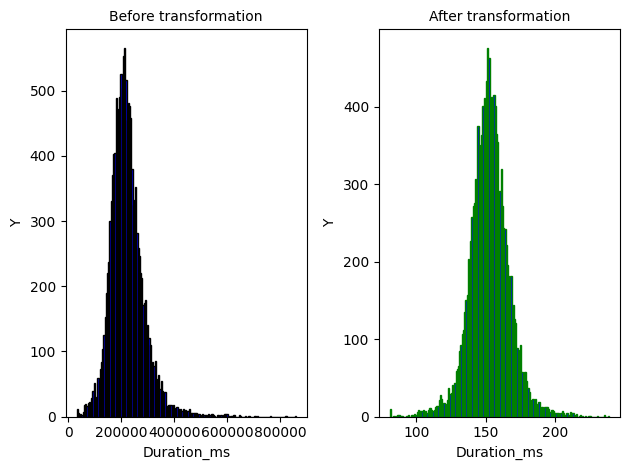

Lambda value used for Transformation: 0.31773060804228004


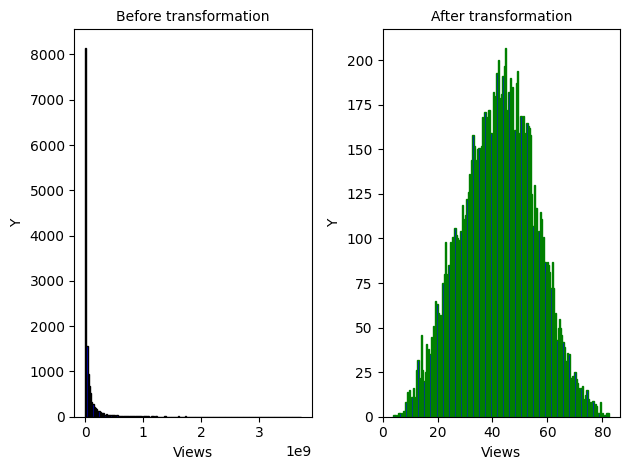

Lambda value used for Transformation: 0.10156045550436


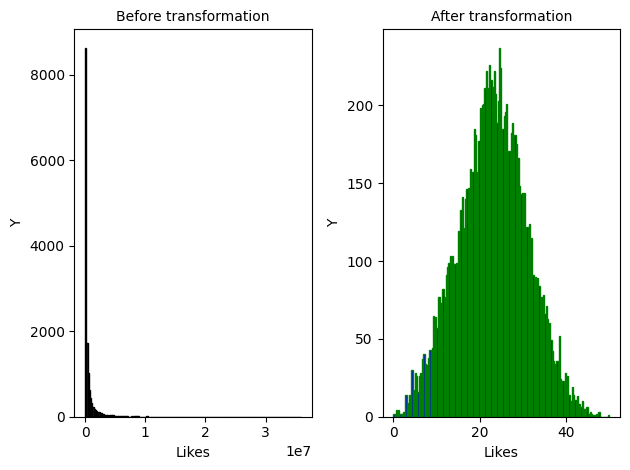

Lambda value used for Transformation: 0.10579677750625552


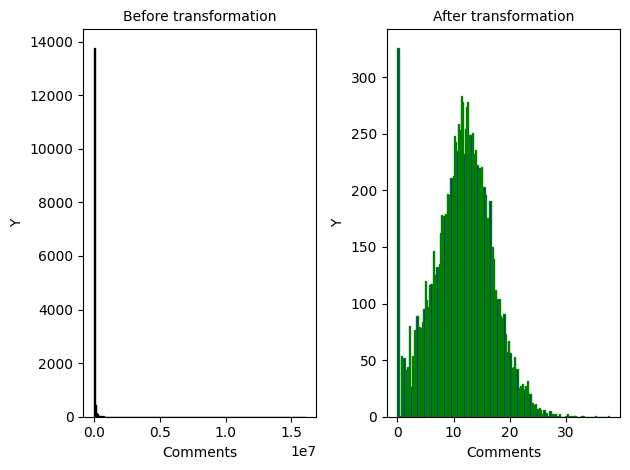

Lambda value used for Transformation: 0.08847159950775114


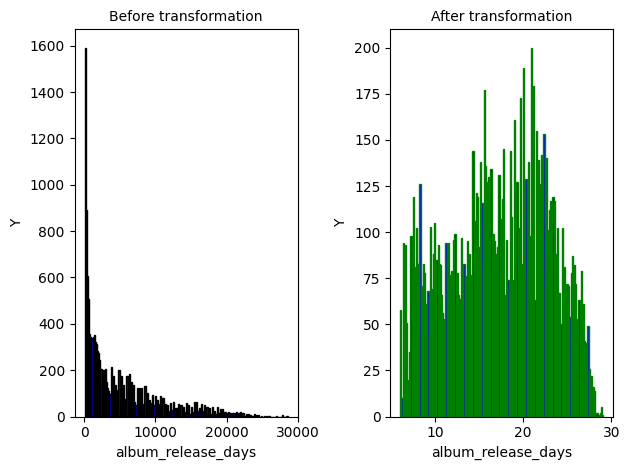

Lambda value used for Transformation: 0.1770091103885189


In [86]:
columns_box=['Duration_ms','Views','Likes','Comments','album_release_days']
transformed_columns=[]
for col in columns_box:
    fitted_data, fitted_lambda=boxcoxTransformation(X[col]+1,col)
    X[col]=fitted_data

In [87]:
X.loc[:,['Duration_ms','Views','Likes','Comments','album_release_days']]

,Duration_ms,Views,Likes,Comments,album_release_days
0,167.074698,46.675102,23.166522,12.372746,26.719152
1,166.757495,30.812368,13.170093,5.442314,24.041767
2,136.287797,12.579590,4.186447,1.474892,27.515094
3,146.324693,27.175092,17.494022,9.156299,6.178444
4,157.774581,32.836618,17.813943,9.696153,12.341833
...,...,...,...,...,...
14555,165.297682,57.056000,30.684283,15.928592,17.522378
14556,141.090155,36.041104,21.406650,10.967710,12.529668
14557,167.838226,38.862054,21.334463,11.140665,23.532891
14558,156.139844,55.820942,30.793593,15.647493,18.152345


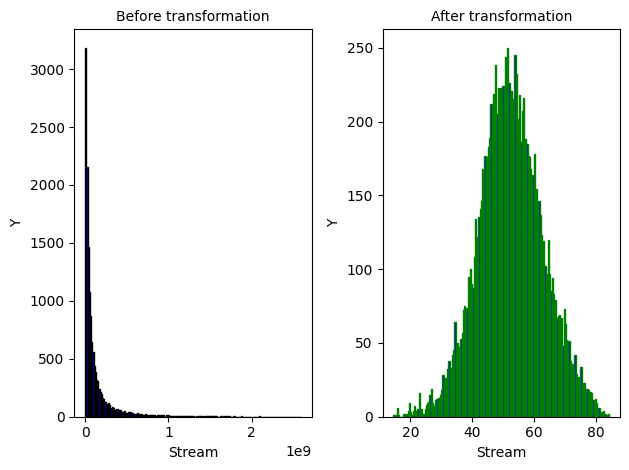

Lambda value used for Transformation: 0.10579595162230807


In [88]:
fitted_data, fitted_lambda=boxcoxTransformation(Y+1,'Stream')
Y=fitted_data

In [89]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

We perform a randomized search. We also tried using a Grid search but the execution time was too high. 

In [90]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'hidden_layer_sizes': [(10,), (50,),(64,), (128,), (256,), (64, 64), (100,),(100,50,), (128, 128), (256, 256), (200,100,50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'solver': ['adam'],
    'max_iter': [50,100,1000]
}
model = MLPRegressor(random_state=0)

# This was discarded as it took to long to compute
#grid_search = GridSearchCV(estimator=model, param_grid=param_distributions, cv=3)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=10, cv=3, random_state=0)

# Fit the model using RandomizedSearchCV
random_search.fit(X, Y)

# Get the best model with the best parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

In [91]:
random_search.best_params_

{'solver': 'adam',
 'max_iter': 1000,
 'hidden_layer_sizes': (50,),
 'alpha': 0.01,
 'activation': 'relu'}

Create the k fold and the model with the best parameters found in the previous step

In [92]:
# Create indices for k-fold cross-validation
k=10
indices = np.arange(len(X))
np.random.shuffle(indices)

# Split the data into k folds
folds = np.array_split(indices, k)

mses = []  # List to store mean absolute errors for each fold
r2 = []  # List to store R2 scores for each fold
rmses = []
nmse = []  # List to store normalized mean squared errors for each fold
results_df = pd.DataFrame(columns=['Fold', 'Accuracy','MAE', 'RMSE', 'R2', 'NMSE'])

for i in range(k):
    # Split the data into train and test sets
    test_indices = folds[i]
    train_indices = np.concatenate([folds[j] for j in range(k) if j != i])
    
    X_train, y_train = X.loc[train_indices], Y[train_indices]
    X_test, y_test = X.loc[test_indices], Y[test_indices]
    #params = random_search.best_params_
    params = random_search.best_params_
    # Define the neural network model
    model = MLPRegressor(**params, random_state=0)

    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_test_pred = model.predict(X_test)
    
    # Evaluate the model and store the scores
    base_accuracy = evaluate(model, X_test, y_test)
    mae = mean_absolute_error(y_test, y_test_pred)
    rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    r2_score_val = r2_score(y_test, y_test_pred)
    normalized_mse = 1 - r2_score_val
    
    print("Mean absolute error =", round(mae, 2))
    print("Root mean squared error =", round(rmse, 2))
    print("R2 score =", round(r2_score_val, 2))
    print("Normalized mean squared error =", round(normalized_mse, 2))
    
    mses.append(round(mae, 2))
    rmses.append(round(rmse, 2))
    r2.append(round(r2_score_val, 2))
    nmse.append(round(normalized_mse, 2))

    results_df = results_df.append({
        'Fold': i+1,
        'Accuracy': base_accuracy,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2_score_val,
        'NMSE': normalized_mse
    }, ignore_index=True)

Average Error: 5.2774 degrees.
Accuracy = 89.33%.
Mean absolute error = 5.28
Root mean squared error = 6.74
R2 score = 0.59
Normalized mean squared error = 0.41


<ipython-input-92-8d58968270e0>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Average Error: 5.3644 degrees.
Accuracy = 89.07%.
Mean absolute error = 5.36
Root mean squared error = 7.05
R2 score = 0.53
Normalized mean squared error = 0.47


<ipython-input-92-8d58968270e0>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Average Error: 5.5777 degrees.
Accuracy = 88.96%.
Mean absolute error = 5.58
Root mean squared error = 7.22
R2 score = 0.52
Normalized mean squared error = 0.48


<ipython-input-92-8d58968270e0>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Average Error: 5.3443 degrees.
Accuracy = 89.06%.
Mean absolute error = 5.34
Root mean squared error = 6.88
R2 score = 0.55
Normalized mean squared error = 0.45


<ipython-input-92-8d58968270e0>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Average Error: 5.2172 degrees.
Accuracy = 89.53%.
Mean absolute error = 5.22
Root mean squared error = 6.76
R2 score = 0.57
Normalized mean squared error = 0.43


<ipython-input-92-8d58968270e0>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Average Error: 5.2418 degrees.
Accuracy = 89.57%.
Mean absolute error = 5.24
Root mean squared error = 6.85
R2 score = 0.57
Normalized mean squared error = 0.43


<ipython-input-92-8d58968270e0>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Average Error: 5.1954 degrees.
Accuracy = 89.35%.
Mean absolute error = 5.2
Root mean squared error = 6.76
R2 score = 0.55
Normalized mean squared error = 0.45


<ipython-input-92-8d58968270e0>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Average Error: 5.2427 degrees.
Accuracy = 89.20%.
Mean absolute error = 5.24
Root mean squared error = 6.86
R2 score = 0.58
Normalized mean squared error = 0.42


<ipython-input-92-8d58968270e0>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Average Error: 5.3539 degrees.
Accuracy = 88.76%.
Mean absolute error = 5.35
Root mean squared error = 7.19
R2 score = 0.56
Normalized mean squared error = 0.44


<ipython-input-92-8d58968270e0>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Average Error: 5.2879 degrees.
Accuracy = 89.48%.
Mean absolute error = 5.29
Root mean squared error = 6.96
R2 score = 0.52
Normalized mean squared error = 0.48


<ipython-input-92-8d58968270e0>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Assess the average performance

In [93]:
results_avg = pd.DataFrame(columns=['Fold', 'MAE', 'RMSE','R2', 'NMSE'])
average_mae = np.mean(mses)
average_rmse = np.mean(rmses)
average_r2 = np.mean(r2)
average_nmse = np.mean(nmse)

print("Average MAE =", round(average_mae, 2))
print("Average RMSE =", round(average_rmse, 2))
print("Average R2 =", round(average_r2, 2))
print("Average NMSE =", round(average_nmse, 2))

results_avg = results_avg.append({
    'Fold': 'Average',
    'MAE': average_mae,
    'RMSE': average_rmse,
    'R2': average_r2,
    'NMSE': average_nmse
}, ignore_index=True)

Average MAE = 5.31
Average RMSE = 6.93
Average R2 = 0.55
Average NMSE = 0.45


<ipython-input-93-0fdcf5bed280>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_avg = results_avg.append({


In [94]:
results_df

,Fold,Accuracy,MAE,RMSE,R2,NMSE
0,1.0,89.331795,5.277448,6.735505,0.590535,0.409465
1,2.0,89.065783,5.364401,7.054644,0.530666,0.469334
2,3.0,88.956776,5.577687,7.224946,0.520168,0.479832
3,4.0,89.063759,5.344327,6.881017,0.554688,0.445312
4,5.0,89.530154,5.217197,6.756547,0.571858,0.428142
5,6.0,89.571793,5.241846,6.854159,0.572966,0.427034
6,7.0,89.348493,5.195443,6.755450,0.547277,0.452723
7,8.0,89.202424,5.242694,6.860113,0.582993,0.417007
8,9.0,88.758986,5.353854,7.191495,0.559004,0.440996
9,10.0,89.484989,5.287888,6.955701,0.519200,0.480800


In [95]:
results_avg

,Fold,MAE,RMSE,R2,NMSE
0,Average,5.31,6.927,0.554,0.446


Store the results

In [96]:

results_df.to_csv('drive/MyDrive/ML/proyecto/n_n_results.csv', index=False)

Train the model on the whole train dataset

In [97]:
model = MLPRegressor(**params, random_state=0)
model.fit(X, Y)
y_pred = model.predict(X)

In [98]:
mae = mean_absolute_error(Y, y_pred)
rmse = mean_squared_error(Y, y_pred, squared=False)
r2_score_val = r2_score(Y, y_pred)
normalized_mse = 1 - r2_score_val

print("Mean absolute error =", round(mae, 2))
print("Root mean squared error =", round(rmse, 2))
print("R2 score =", round(r2_score_val, 2))
print("Normalized mean squared error =", round(normalized_mse, 2))

Mean absolute error = 5.28
Root mean squared error = 6.89
R2 score = 0.56
Normalized mean squared error = 0.44


Store the model

In [99]:
# Store the model as a pickle file
joblib.dump(model, 'drive/MyDrive/ML/proyecto/model_nn.pkl')

['drive/MyDrive/ML/proyecto/model_nn.pkl']

Estimate predictive error of trained final model on test set

In [100]:
df_test=pd.read_csv('drive/MyDrive/ML/proyecto/X_test.csv')
df_test.head()

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,...,trackLength,albumLength,ArtistEqualsChannel,album_tracks,available_markets,album_release_days,Album_type_album,Album_type_compilation,Album_type_single,target
0,0.384,0.561,3.0,-10.059,0.0296,0.373000,0.253000,0.0775,0.159,136.136,...,8,12,0,7,184,10682,1,0,0,153621659.0
1,0.907,0.644,2.0,-5.522,0.3530,0.392000,0.000000,0.5430,0.721,123.979,...,6,10,0,18,184,121,1,0,0,14679203.0
2,0.468,0.907,0.0,-3.884,0.0664,0.009870,0.046800,0.1090,0.168,119.993,...,17,18,0,12,184,5744,1,0,0,24288930.0
3,0.580,0.701,4.0,-6.643,0.0450,0.012000,0.018100,0.3020,0.263,104.967,...,13,15,1,31,2,7760,1,0,0,44120883.0
4,0.549,0.810,11.0,-4.001,0.0328,0.000298,0.000003,0.1560,0.410,133.985,...,14,17,0,11,183,8125,1,0,0,17987369.0


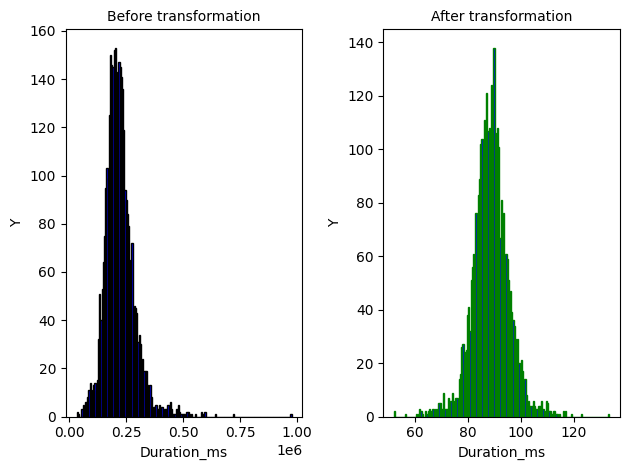

Lambda value used for Transformation: 0.2588560954256029


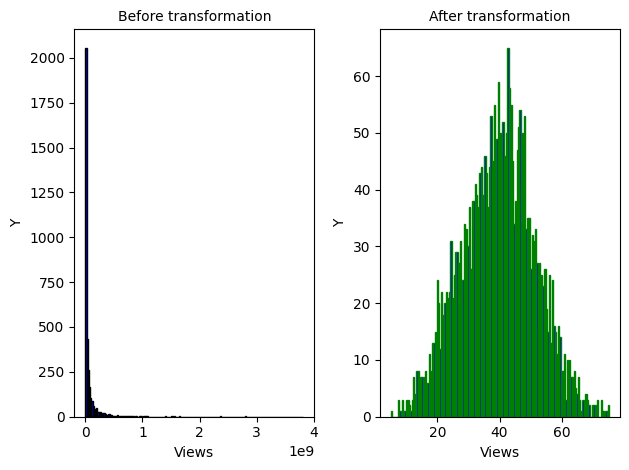

Lambda value used for Transformation: 0.09519277932522469


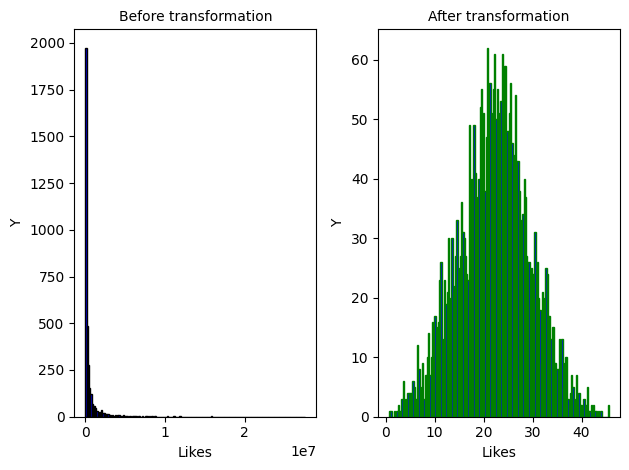

Lambda value used for Transformation: 0.10026861784426153


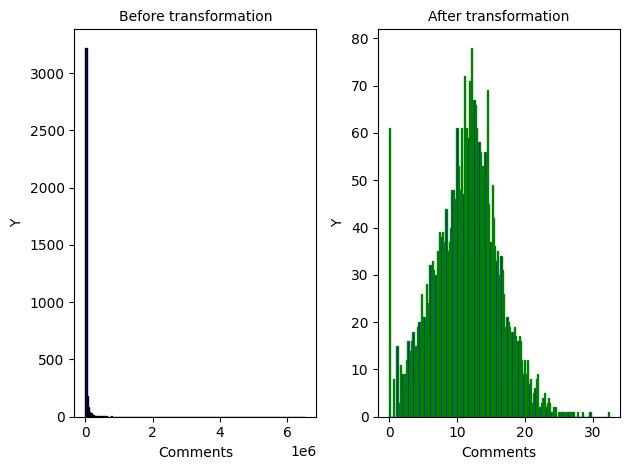

Lambda value used for Transformation: 0.08325825558692235


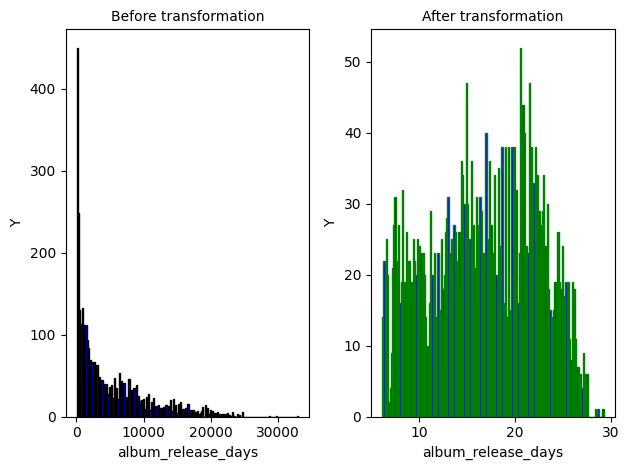

Lambda value used for Transformation: 0.17321748989965355


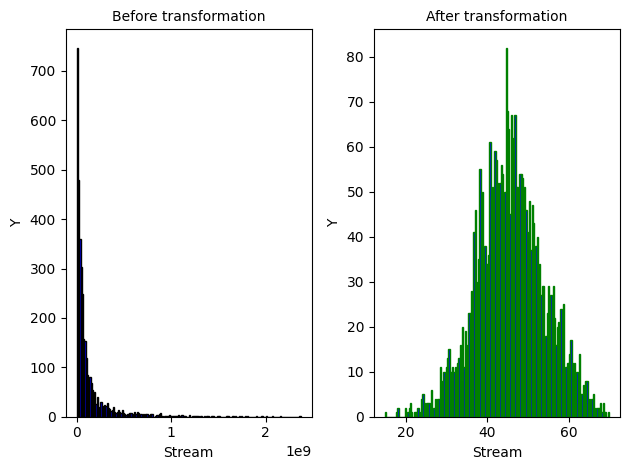

Lambda value used for Transformation: 0.09359183672903401


In [101]:
Y_test=df_test['target'].values
X_test=df_test.drop(['target'],axis=1)

columns_box=['Duration_ms','Views','Likes','Comments','album_release_days']
transformed_columns=[]
for col in columns_box:
    fitted_data, fitted_lambda=boxcoxTransformation(X_test[col]+1,col)
    X_test[col]=fitted_data


fitted_data, fitted_lambda=boxcoxTransformation(Y_test+1,'Stream')
Y_test=fitted_data

In [102]:
model_predict = model.predict(X_test)

In [103]:
base_accuracy = evaluate(model, X_test, Y_test)
y_test_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(Y_test, y_test_pred)
rmse = mean_squared_error(Y_test, y_test_pred, squared=False)
r2_score_val = r2_score(Y_test, y_test_pred)
normalized_mse = 1 - r2_score_val

print("Mean absolute error =", round(mae, 2))
print("Root mean squared error =", round(rmse, 2))
print("R2 score =", round(r2_score_val, 2))
print("Normalized mean squared error =", round(normalized_mse, 2))

Average Error: 5.3416 degrees.
Accuracy = 87.86%.
Mean absolute error = 5.34
Root mean squared error = 6.8
R2 score = 0.32
Normalized mean squared error = 0.68


In [104]:
# Create a dataframe with actual and predicted values
df_predicted = pd.DataFrame({'Actual': Y_test, 'Predicted': y_test_pred})

# Display the dataframe
print(df_predicted)

         Actual  Predicted
0     51.681201  49.415887
1     39.377156  35.238275
2     41.793149  46.841479
3     44.808323  54.179217
4     40.338518  47.305046
...         ...        ...
3636  41.191075  30.198751
3637  46.765751  45.895749
3638  44.924816  35.262897
3639  56.531334  43.182374
3640  42.643843  43.421771

[3641 rows x 2 columns]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c6bca811-fc7a-456b-b8f3-4c66c733d95a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>